# DL model for gold price prediction

## GET data from my github

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/faiisu/DL_LSTM_XAUUSD_predict/main/data/M1_Y3.csv"
df = pd.read_csv(url)

## Data cleaning

In [2]:
#drop real_volumn columns (all 0)
df_cl = df[df.columns[df.columns != "real_volume"]]

#time column to datetime
df_cl['time'] = pd.to_datetime(df_cl['time'])
df_cl = df_cl.sort_values('time')

# drop na
df_cl = df_cl.dropna()
df_cl.head()


C:\Users\sukum\AppData\Local\Temp\ipykernel_21180\3165619004.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl['time'] = pd.to_datetime(df_cl['time'])


,time,Open,High,Low,Close,TickVolume,Spread
0,2025-07-03 18:02:00+00:00,3328.741,3329.104,3328.741,3329.049,46,160
1,2025-07-03 18:03:00+00:00,3329.049,3329.049,3328.882,3329.027,23,160
2,2025-07-03 18:04:00+00:00,3329.026,3329.026,3328.598,3328.737,57,160
3,2025-07-03 18:05:00+00:00,3328.740,3329.134,3328.647,3329.016,52,160
4,2025-07-03 18:06:00+00:00,3329.015,3329.129,3328.962,3328.962,26,160


## Pre-processing

In [3]:
import numpy as np

#select feature
features = ["time","Open", "High", "Low", "Close", "TickVolume"]
df_cl = df_cl[features]

# --- add feature --- 

# --------------------------
# 1) Returns & Momentum
# --------------------------

df_cl["return_1"] = df_cl["Close"].diff(1)
df_cl["return_3"] = df_cl["Close"].diff(3)
df_cl["return_5"] = df_cl["Close"].diff(5)

df_cl["log_return_1"] = np.log(df_cl["Close"] / df_cl["Close"].shift(1))

df_cl["price_change"] = df_cl["Close"] - df_cl["Open"]


# --------------------------
# 2) EMA Indicators
# --------------------------f

def EMA(series, span):
    return series.ewm(span=span, adjust=False).mean()

df_cl["EMA_5"] = EMA(df_cl["Close"], 5)
df_cl["EMA_9"] = EMA(df_cl["Close"], 9)
df_cl["EMA_20"] = EMA(df_cl["Close"], 20)

df_cl["Diff_EMA5"] = df_cl["Close"] - df_cl["EMA_5"]
df_cl["Diff_EMA20"] = df_cl["Close"] - df_cl["EMA_20"]


# --------------------------
# 3) Volatility
# --------------------------

# Rolling Standard Deviation
df_cl["vol_10"] = df_cl["log_return_1"].rolling(10).std()
df_cl["vol_20"] = df_cl["log_return_1"].rolling(20).std()

# ATR (Average True Range)
df_cl["tr"] = np.maximum(
    df_cl["High"] - df_cl["Low"],
    np.maximum(abs(df_cl["High"] - df_cl["Close"].shift(1)),
               abs(df_cl["Low"] - df_cl["Close"].shift(1)))
)
df_cl["ATR_5"] = df_cl["tr"].rolling(5).mean()

df_cl["Range"] = df_cl["High"] - df_cl["Low"]


# --------------------------
# 4) TickVolume-based Features
# --------------------------

df_cl["TickVolume_MA5"] = df_cl["TickVolume"].rolling(5).mean()
df_cl["TickVolume_Change"] = df_cl["TickVolume"].diff(1)


# --------------------------
# 5) Time Features (สำคัญมาก)
# --------------------------

if "time" in df_cl.columns:
    df_cl["minute"] = df_cl["time"].dt.minute
    df_cl["hour"] = df_cl["time"].dt.hour
else:
    print("WARNING: no 'time' column found, time features skipped.")
    df_cl["minute"] = 0
    df_cl["hour"] = 0

# Encode cyclic
df_cl["minute_sin"] = np.sin(2 * np.pi * df_cl["minute"] / 60)
df_cl["minute_cos"] = np.cos(2 * np.pi * df_cl["minute"] / 60)

df_cl["hour_sin"] = np.sin(2 * np.pi * df_cl["hour"] / 24)
df_cl["hour_cos"] = np.cos(2 * np.pi * df_cl["hour"] / 24)


# --------------------------
# Cleanup
# --------------------------

df_cl = df_cl.dropna()
df_cl = df_cl[df_cl.columns[df_cl.columns != "time"]]
df_cl = df_cl.reset_index(drop=True)

df_cl.head()

,Open,High,Low,Close,TickVolume,return_1,return_3,return_5,log_return_1,price_change,...,ATR_5,Range,TickVolume_MA5,TickVolume_Change,minute,hour,minute_sin,minute_cos,hour_sin,hour_cos
0,3329.146,3329.424,3329.040,3329.222,63,0.078,0.343,1.168,0.000023,0.076,...,0.4378,0.384,50.0,29.0,22,18,0.743145,-0.669131,-1.0,-1.836970e-16
1,3329.256,3329.352,3329.166,3329.241,34,0.019,0.359,0.608,0.000006,-0.015,...,0.3400,0.186,48.2,-29.0,23,18,0.669131,-0.743145,-1.0,-1.836970e-16
2,3329.170,3329.275,3328.626,3328.868,64,-0.373,-0.276,-0.011,-0.000112,-0.302,...,0.3682,0.649,47.8,30.0,24,18,0.587785,-0.809017,-1.0,-1.836970e-16
3,3328.890,3329.087,3328.889,3328.891,40,0.023,-0.331,0.009,0.000007,0.001,...,0.3572,0.198,47.0,-24.0,25,18,0.500000,-0.866025,-1.0,-1.836970e-16
4,3328.892,3329.066,3328.759,3328.953,40,0.062,-0.288,-0.191,0.000019,0.061,...,0.3490,0.307,48.2,0.0,26,18,0.406737,-0.913545,-1.0,-1.836970e-16


## window & lebeling

In [29]:
import numpy as np
from sklearn.preprocessing import StandardScaler

window_size = 120
horizon = 15

scaled_data = df_cl.values


X_list = []
y_list = []

for i in range(len(scaled_data) - window_size - horizon + 1):
    x_window = scaled_data[i : i + window_size]   # (window, num_features)

    #using real price for label
    next_pred_price = df_cl.iloc[i + window_size + horizon - 1, 3]
    last_close      = df_cl.iloc[i + window_size - 1, 3]

    y_value = int(next_pred_price > last_close)   # 1 = up, 0 = down

    X_list.append(x_window)
    y_list.append(y_value)

X = np.array(X_list)  # shape (num_samples, window, num_features)
y = np.array(y_list)


## Train / Test / Validate Split

In [30]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [31]:
# Split train / test / validate
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.5, shuffle=False
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

## Balance train set

In [32]:
# Balance train set (undersampling)
idx_0 = np.where(y_train == 0)[0]
idx_1 = np.where(y_train == 1)[0]

min_count = min(len(idx_0), len(idx_1))

idx_0_bal = idx_0[:min_count]
idx_1_bal = idx_1[:min_count]

balanced_idx = np.concatenate([idx_0_bal, idx_1_bal])
balanced_idx.sort() 

# Balanced train set
X_train = X_train[balanced_idx]
y_train = y_train[balanced_idx]

print(len(y_train), "samples")
print("class 0:", sum(y_train == 0))
print("class 1:", sum(y_train == 1))


49670 samples
class 0: 24835
class 1: 24835


In [33]:
scaler = StandardScaler()

# fit x_train (flatten)
n_train, seq_len, n_features = X_train.shape

X_train_flat = X_train.reshape(-1, n_features)   # (n_train * seq_len, n_features)

scaler.fit(X_train_flat)


def scale_3d(X, scaler):
    n_samples, seq_len, n_features = X.shape
    X_flat = X.reshape(-1, n_features)
    X_flat_scaled = scaler.transform(X_flat)
    return X_flat_scaled.reshape(n_samples, seq_len, n_features)

X_train_scaled = scale_3d(X_train, scaler)
X_val_scaled   = scale_3d(X_val,   scaler)
X_test_scaled  = scale_3d(X_test,  scaler)

# Tensor for pytorch
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train).long()

X_val_tensor = torch.from_numpy(X_val_scaled).float()
y_val_tensor = torch.from_numpy(y_val).long()

X_test_tensor = torch.from_numpy(X_test_scaled).float()
y_test_tensor = torch.from_numpy(y_test).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)


## Data loader

In [34]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

## Model

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_classes: int = 2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)
        self.fc1   = nn.Linear(hidden_size, hidden_size//2)
        self.fc2 = nn.Linear(hidden_size//2, num_classes)
        
    def forward(self, x):
        out, _ = self.lstm(x)       # (B, W, H)
        last = out[:, -1, :]        # (B, H)
        fc1 = self.fc1(last)
        h = F.relu(fc1)
        return self.fc2(h)   

## Train Loop

In [37]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from IPython.display import clear_output

Epoch [5/5]
Train Loss: 0.6709 | Train Acc: 0.5747
Val   Loss: 0.7050 | Val   Acc: 0.4943
Best Val Loss: 0.6937


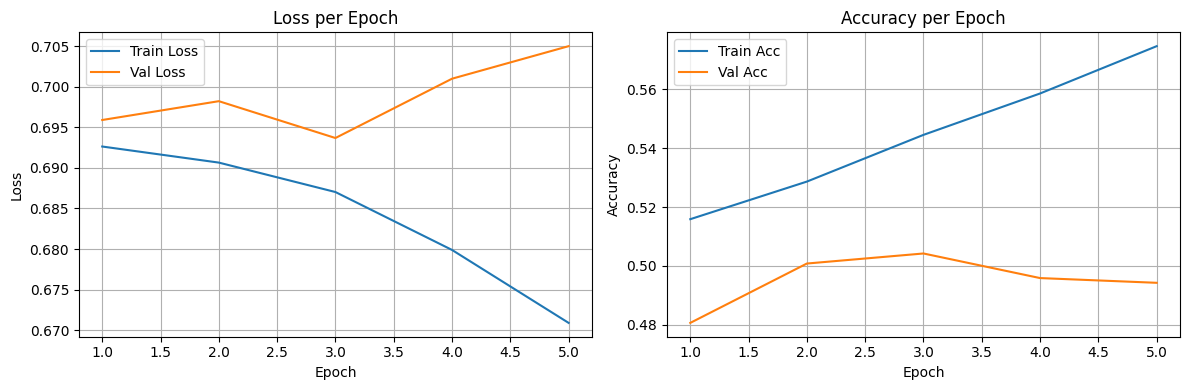

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output

model = LSTM_Model(input_size=len(df_cl.columns), hidden_size=512, num_classes=2)

lr = 1e-4
epochs = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

file = open("best_loss.txt", "r") 
best_val_loss = str(file.readline(0))

if ( len(best_val_loss) == 0): best_val_loss = 999
else : best_val_loss = float(best_val_loss)

file = open("best_acc.txt", "r") 
best_acc = str(file.readline(0))

if ( len(best_acc) == 0): best_acc = 0
else : best_acc = float(best_acc)

best_epoch = 0
save_path = "best_lstm_model.pth"

for epoch in range(1, epochs + 1):
    # ---------- TRAIN ----------
    model.train()
    total = correct = 0
    running_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        correct      += (logits.argmax(1) == yb).sum().item()
        total        += yb.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    # ---------- VALIDATE ----------
    model.eval()
    v_total = v_correct = 0
    v_loss_sum = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            val_loss_batch = criterion(logits, yb)

            v_loss_sum += val_loss_batch.item() * xb.size(0)
            v_correct  += (logits.argmax(1) == yb).sum().item()
            v_total    += yb.size(0)

    val_loss = v_loss_sum / v_total
    val_acc  = v_correct / v_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    #save best model
    if train_acc > 0.51:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_loss": val_loss,
            }, save_path)
            print(f"Saved New Best Model at Epoch {epoch} (val_loss={val_loss:.4f})")
            open("best_loss.txt", "w+").write(str(best_val_loss))
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_loss": val_loss,
            }, "best_lstm_model_acc.pth")
            print(f"Saved New Best Model at Epoch {epoch} (val_loss={val_loss:.4f})")
            open("best_acc.txt", "w+").write(str(best_acc))
    


    # ---------- Plot ----------
    clear_output(wait=True)

    print(f"Epoch [{epoch}/{epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print(f"Best Val Loss: {best_val_loss:.4f}")

    epochs_range = range(1, epoch + 1)
    plt.figure(figsize=(12, 4))

    # --- Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()
    plt.grid(True)

    # --- Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label="Train Acc")
    plt.plot(epochs_range, val_accs,   label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



## Test

In [55]:
from sklearn.metrics import classification_report
import numpy as np

checkpoint = torch.load("best_lstm_model_acc.pth", map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        logits = model(xb) #[B, n_classes]
        # print(logits)
        probs = F.softmax(logits, dim=1)  # (B, 2)
        preds = logits.argmax(1) #[B]
        probs = probs.cpu().numpy()
        
        all_preds.append(preds.cpu())
        all_true.append(yb.cpu())
        
y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_true).numpy()
mapping = {0:"down", 1:"up"}
y_pred = np.array([mapping[p] for p in y_pred])
y_true = np.array([mapping[t] for t in y_true])

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

        down       0.46      0.33      0.38     11215
          up       0.55      0.67      0.61     13661

    accuracy                           0.52     24876
   macro avg       0.50      0.50      0.50     24876
weighted avg       0.51      0.52      0.51     24876

